<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/Finalsims_EfficientNetB3_with_original_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]

['PaperedControl21v_light.tif',
 'PaperedControl21d.tif',
 'PaperedControl21d_light.tif',
 'PaperedControl22v.tif']

In [ ]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [ ]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [ ]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [ ]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl21d.tif,marked
1,PaperedControl22v.tif,marked
2,PaperedControl22d.tif,marked
3,PaperedControl23v.tif,marked
4,PaperedControl23d.tif,marked
...,...,...
752,PaperedControl19v.tif,marked
753,PaperedControl19d.tif,marked
754,PaperedControl20v.tif,marked
755,PaperedControl20d.tif,marked


In [ ]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

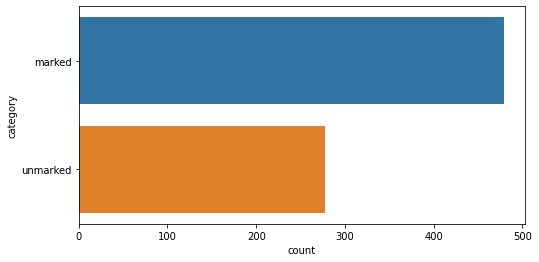

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [ ]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [ ]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
tmp_df = df.sample(9)
tmp_df

,filename,category
359,NoPaperedGreen14d.tif,unmarked
150,PaperedTransparent17v.tif,marked
298,PaperedTransparent91v.tif,marked
510,NoPaperedMixed13d.tif,unmarked
673,PaperedMixed44d.tif,marked
542,NoPaperedMixed29v.tif,unmarked
485,NoPaperedGreen85d.tif,unmarked
321,PaperedTransparent102d.tif,marked
511,NoPaperedMixed13v.tif,unmarked


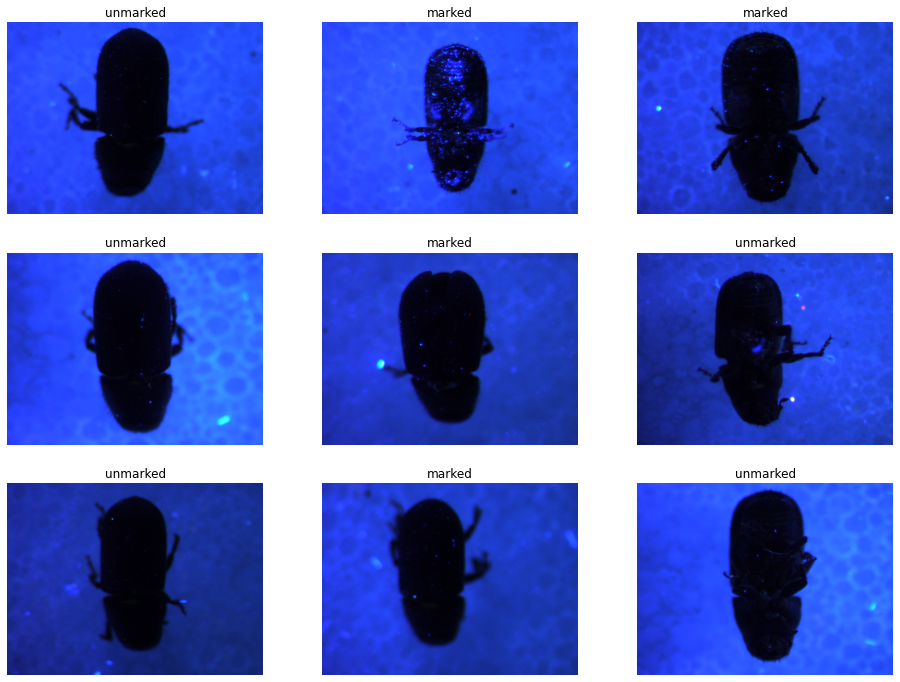

In [ ]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

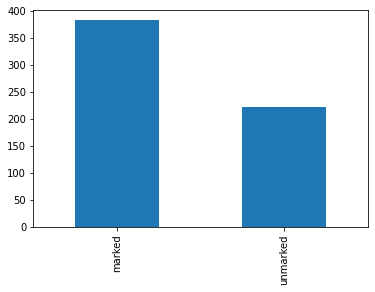

In [ ]:
train_df['category'].value_counts().plot.bar()

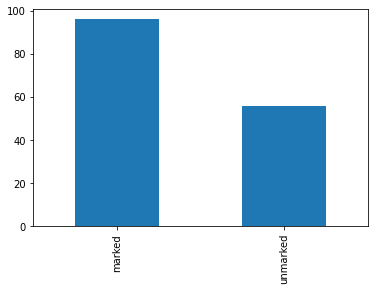

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 50

In [ ]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [ ]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [ ]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames belonging to 2 classes.


In [ ]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
def create_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 600, 600, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 600, 600, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 601, 601, 3)  0           ['normalization[0][0]'

In [ ]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [ ]:
def Model_fit():
    
    model = create_model()
    '''Compiling the model'''
    #unfreeze_model(model)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("B0_original_images_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('/content/drive/MyDrive/finalsims_B0_original.h5')  
    return history

In [ ]:
%%time
results = Model_fit()

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.9821 - accuracy: 0.6378 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


12/12 [==============================] - 909s 73s/step - loss: 0.9821 - accuracy: 0.6378 - val_loss: 0.5443 - val_accuracy: 0.7267 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 705s 58s/step - loss: 0.8249 - accuracy: 0.7063 - val_loss: 0.5149 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 706s 58s/step - loss: 0.8169 - accuracy: 0.7225 - val_loss: 0.4733 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 717s 59s/step - loss: 0.7919 - accuracy: 0.7279 - val_loss: 0.4463 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 744s 61s/step - loss: 0.7411 - accuracy: 0.7300 - val_loss: 0.4250 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 726s 60s/step - loss: 0.6324 - accuracy: 0.7586 - val_loss: 0.4254 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - ETA: 0s - loss: 0.7003 - accu

In [ ]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8144144415855408
Val_Cat-Acc:  0.8666666746139526


In [ ]:
print('Train_Cat-Loss: ', min(results.history['loss']))
print('Val_Cat-Loss: ', min(results.history['val_loss']))

Train_Cat-Loss:  0.4613346755504608
Val_Cat-Loss:  0.34071221947669983


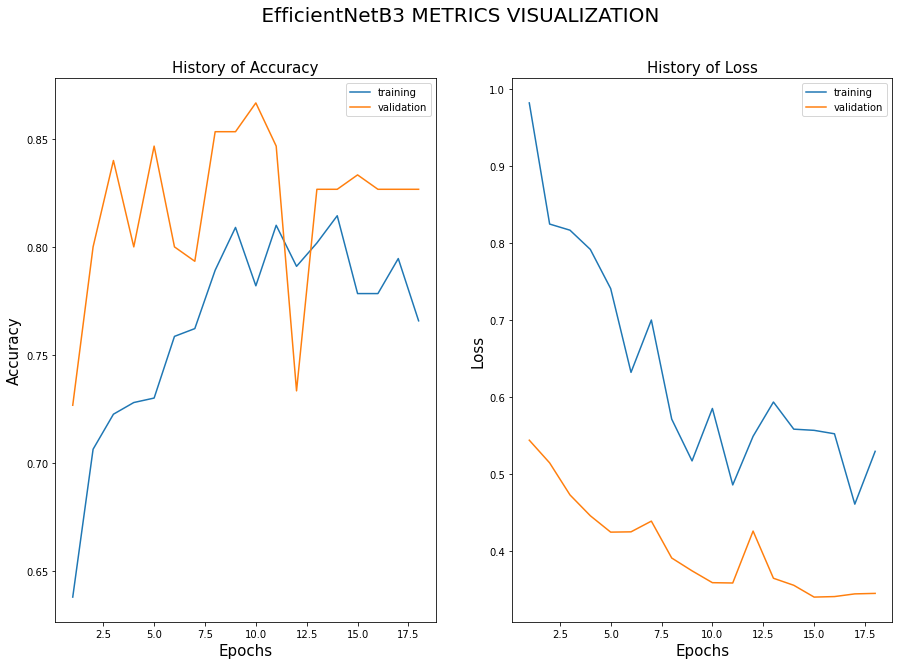

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" EfficientNetB3 METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [ ]:
final_model = keras.models.load_model('/content/drive/MyDrive/finalsims_B0_original.h5')

In [ ]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
545,NoPaperedMixed30d.tif,unmarked
118,PaperedTransparent1v.tif,marked
751,PaperedControl18d.tif,marked
257,PaperedTransparent70d.tif,marked
692,NoPaperedMixed4d.tif,unmarked
620,PaperedMixed18v.tif,marked
299,PaperedTransparent91d.tif,marked
734,NoPaperedGreen9d.tif,unmarked
75,PaperedControl58d.tif,marked
559,NoPaperedMixed37d.tif,unmarked


In [ ]:
nb_samples = tmp_df1.shape[0]
nb_samples


10

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator = test_gen.flow_from_dataframe(
    tmp_df1, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10 validated image filenames.


In [ ]:
predict = final_model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [ ]:
tmp_df1['prediction'] = np.argmax(predict, axis=-1)
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
545,NoPaperedMixed30d.tif,unmarked,marked
118,PaperedTransparent1v.tif,marked,marked
751,PaperedControl18d.tif,marked,marked
257,PaperedTransparent70d.tif,marked,marked
692,NoPaperedMixed4d.tif,unmarked,marked
620,PaperedMixed18v.tif,marked,marked
299,PaperedTransparent91d.tif,marked,marked
734,NoPaperedGreen9d.tif,unmarked,marked
75,PaperedControl58d.tif,marked,marked
559,NoPaperedMixed37d.tif,unmarked,marked


In [ ]:
to_samples = df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 152 validated image filenames.


In [ ]:
predict = final_model.predict(test_generator1, steps=np.ceil(152/BATCH_SIZE))

In [ ]:
predict

array([[0.70744133, 0.22179759],
       [0.53974336, 0.14526302],
       [0.5299001 , 0.3033629 ],
       [0.45479602, 0.17187434],
       [0.5844461 , 0.07146388],
       [0.45445737, 0.18010804],
       [0.61992574, 0.08114138],
       [0.6225848 , 0.14028913],
       [0.41749942, 0.1953915 ],
       [0.37265402, 0.15737641],
       [0.2531339 , 0.22387776],
       [0.36044246, 0.2488758 ],
       [0.4486559 , 0.19547665],
       [0.42044023, 0.11969173],
       [0.51097125, 0.11439517],
       [0.38508505, 0.16636932],
       [0.6283257 , 0.1165871 ],
       [0.59548897, 0.15801466],
       [0.5522692 , 0.14004582],
       [0.32464498, 0.311384  ],
       [0.5737055 , 0.243777  ],
       [0.546009  , 0.09398705],
       [0.40261057, 0.11757049],
       [0.500663  , 0.21964675],
       [0.29717314, 0.23125333],
       [0.6739301 , 0.33410776],
       [0.6253597 , 0.1488516 ],
       [0.3597831 , 0.17735416],
       [0.43355197, 0.23608458],
       [0.392594  , 0.23541823],
       [0.

In [ ]:
validate_df['prediction'] = np.argmax(predict, axis=-1)
validate_df["prediction"] = validate_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,prediction
0,PaperedControl46v.tif,marked,marked
1,NoPaperedMixed38v.tif,unmarked,marked
2,NoPaperedGreen43v.tif,unmarked,marked
3,NoPaperedMixed7v.tif,unmarked,marked
4,PaperedTransparent9v.tif,marked,marked
...,...,...,...
147,PaperedTransparent99d.tif,marked,marked
148,NoPaperedGreen61v.tif,unmarked,marked
149,NoPaperedGreen57d.tif,unmarked,marked
150,PaperedControl65v.tif,marked,marked


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

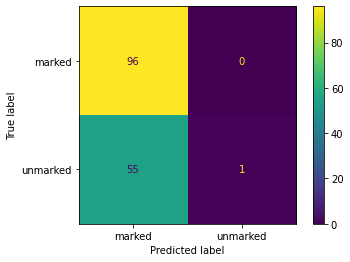

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d") 

In [44]:
cm

array([[96,  0],
       [55,  1]])

In [45]:
validation_accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])

In [46]:
validation_accuracy

0.6381578947368421